# MNIST: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def renormalize_image(image, threshold=False, threshold_value=10):
    """
    Renormalize an image such that pixel values are between 0 and 255.
    Optionally, set small pixel values to 0.

    Parameters:
    - image: numpy array with shape (28, 28)
    - threshold: bool, if True, set small pixel values to 0
    - threshold_value: int, the value below which pixels are set to 0 (if threshold is True)

    Returns:
    - renormalized_image: numpy array with shape (28, 28), pixel values between 0 and 255
    """
    # Ensure the image is a numpy array
    image = np.array(image)

    # Renormalize pixel values to be between 0 and 255
    min_val = np.min(image)
    max_val = np.max(image)
    renormalized_image = 255 * (image - min_val) / (max_val - min_val)

    # Apply threshold if needed
    if threshold:
        renormalized_image[renormalized_image < threshold_value] = 0

    return renormalized_image.astype(np.uint8)

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Setup

### Dataset

In [3]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)
train_size = 100
num_new_samples = 20
plot_num = 20
paper_plot_num = 1
bandwidth = 0.05
k = 8
eps = np.asarray(1.0e-5)

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_digit = []
original_data = []

for digit in range(10):
    class_folder = os.path.join(save_dir, str(digit))
    images = load_images_from_folder(class_folder, max_images=train_size)

    P = []
    for i in range(len(images)):
        img = images[i]
        img = img.resize((28, 28))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_digit.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][i].reshape((28,28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

### Build Dataloader for Later

In [6]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): NumPy array of shape (num, 28*28)
            labels (numpy array): Corresponding labels for each image
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and label for a given index
        image = self.data[idx].reshape(28, 28).astype(np.float32) / 255.0 # Reshape from 28*28 to 28x28
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_data_original = np.array(original_data)
labels = np.repeat(np.arange(10), train_size)
custom_train_dataset = CustomDataset(train_data_original, labels, transform=transforms.ToTensor())
train_loader_original = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Direct Fitting

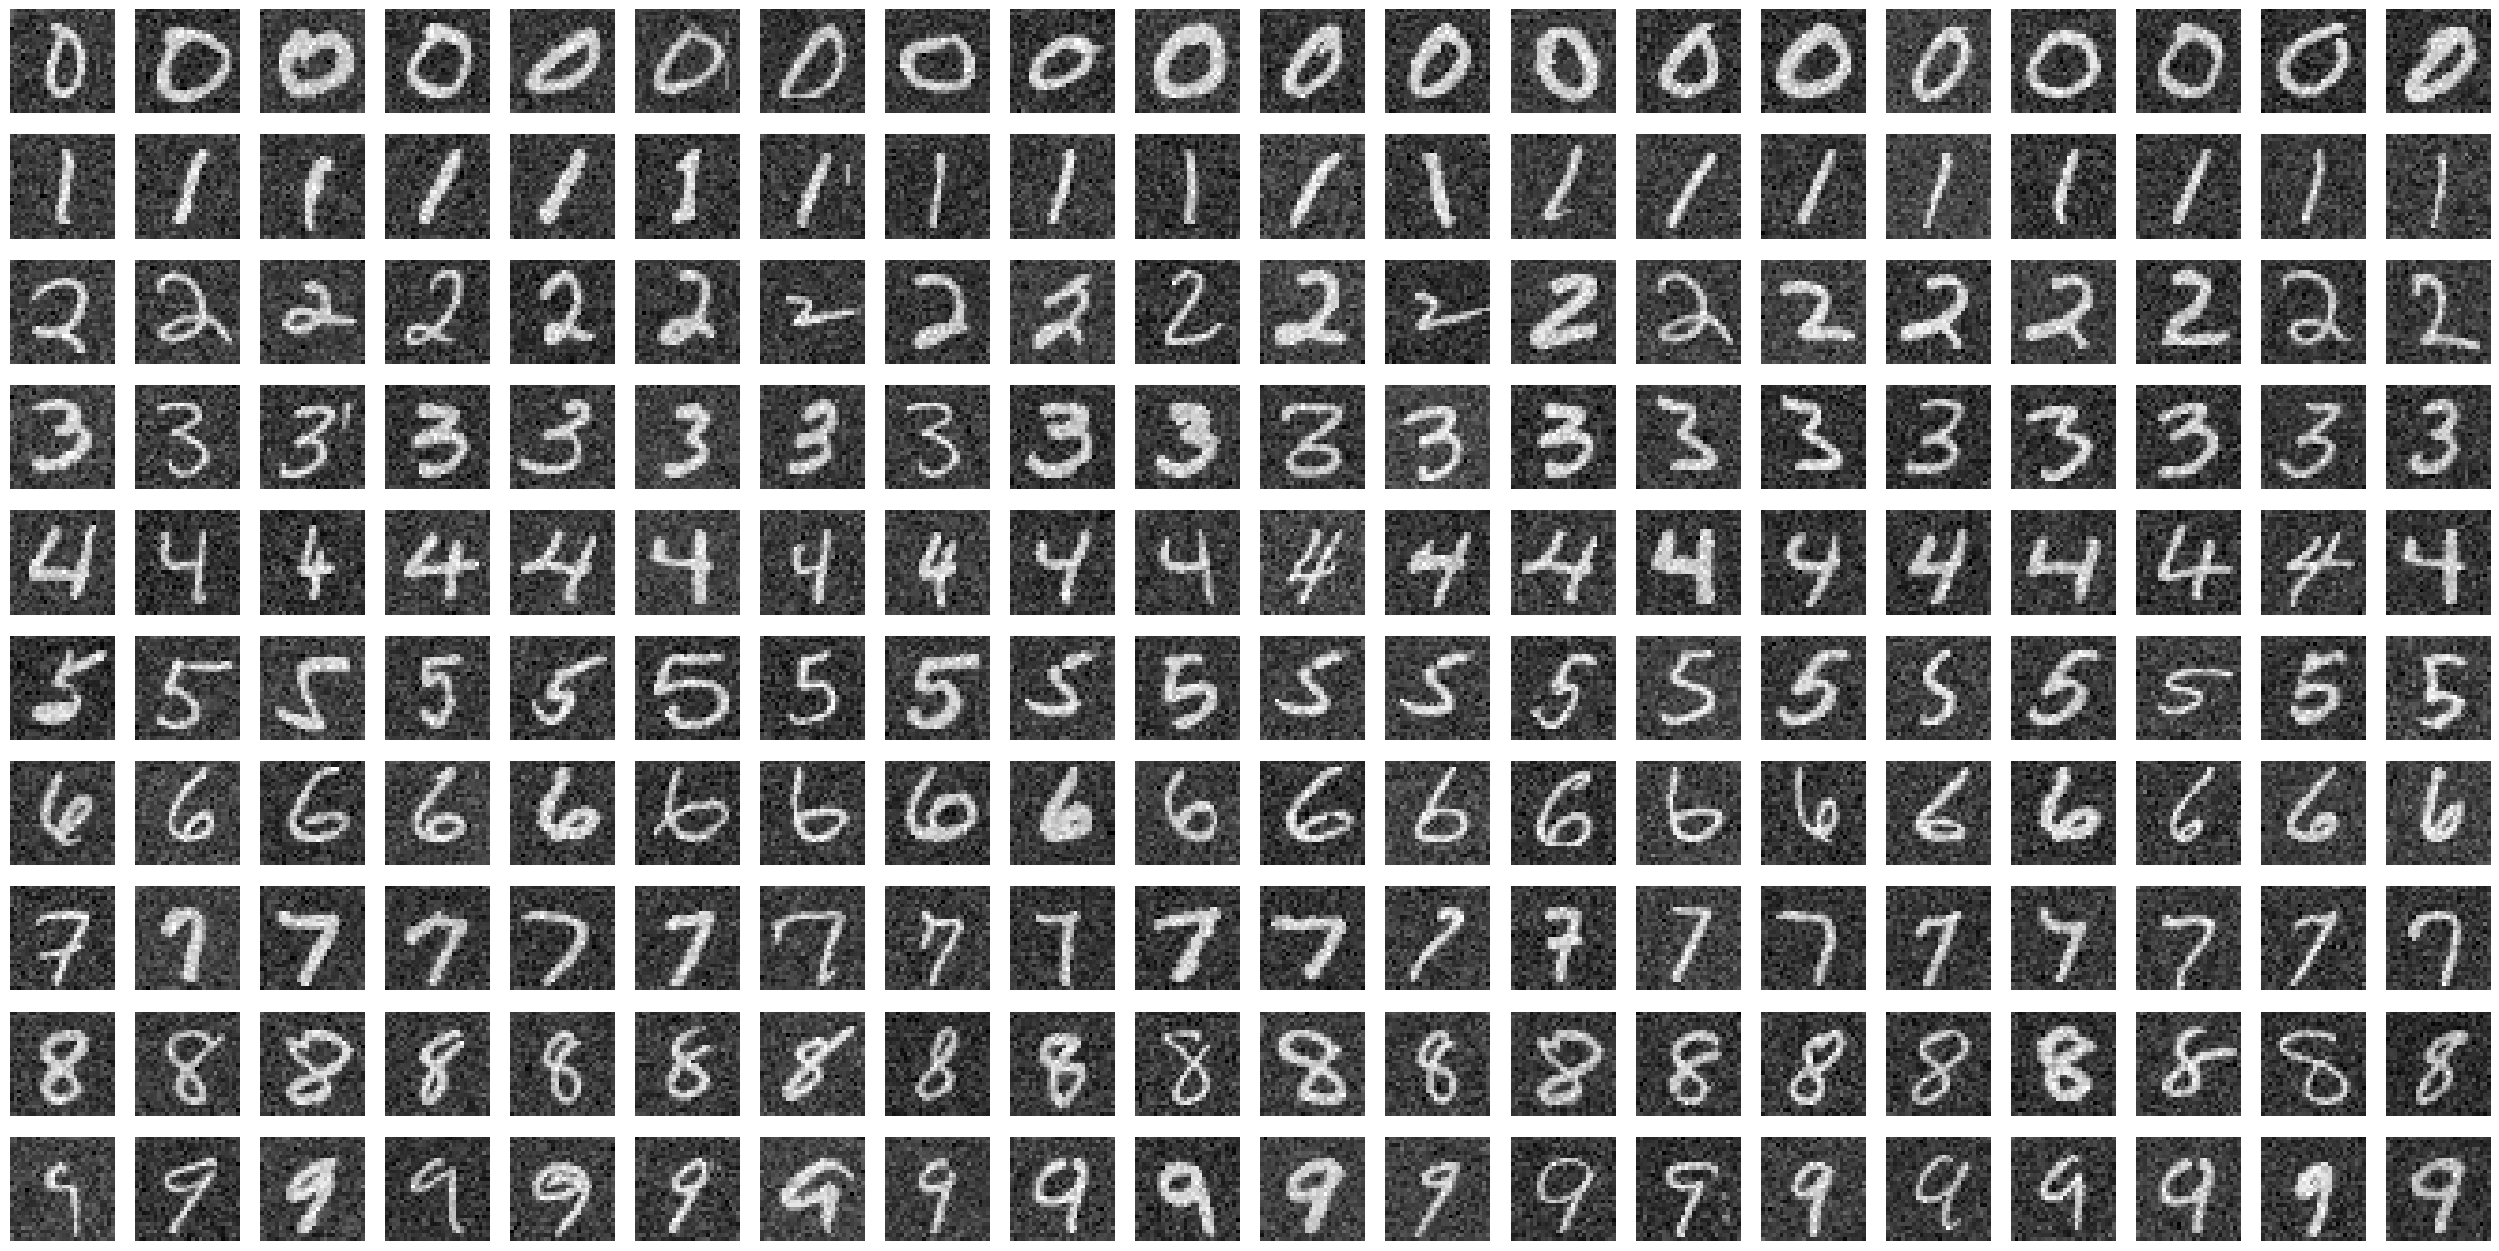

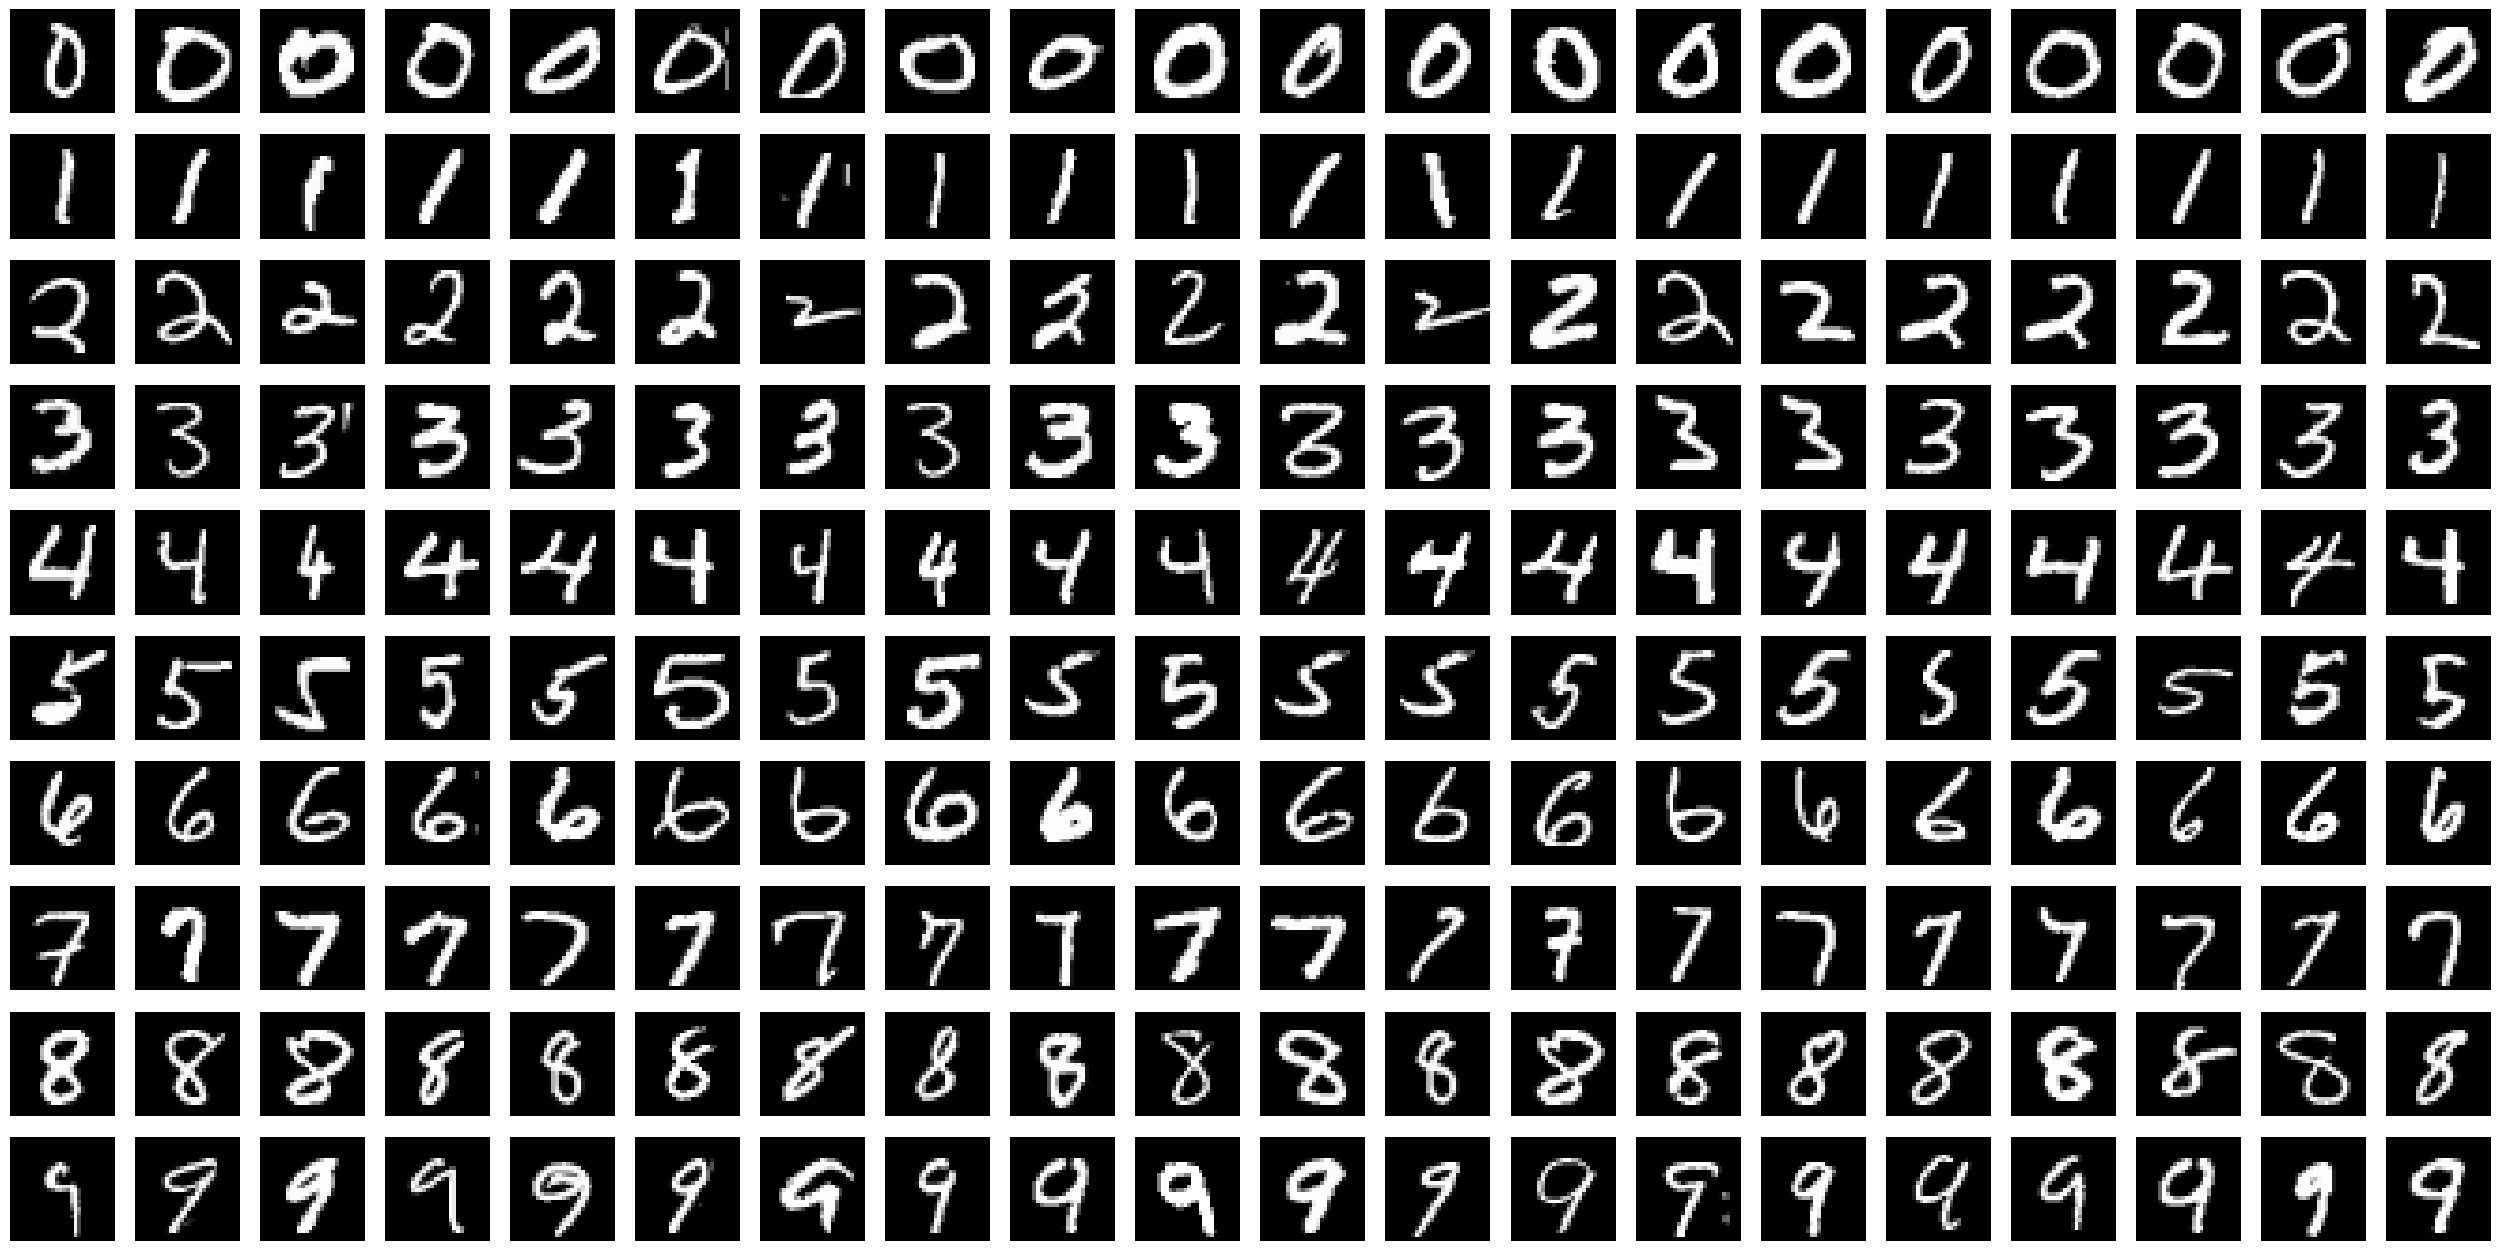

In [7]:
B_LD = ld.default_B(S, len(S), cp.get_array_module(P[0])) # Full Basis (direct fitting essentially)

num_new_samples = 20

sampled_P_digit = []

for digit in range(10):
    reduced_P = vectorize_tensor(P_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(reduced_P)

    # Sample new data from the KDE
    sampled_reduced_P = kde.sample(n_samples=num_new_samples)

    sampled_P = reconstruct_tensor(sampled_reduced_P, (num_new_samples, *S), B_LD)
    sampled_P_digit.append(sampled_P)

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

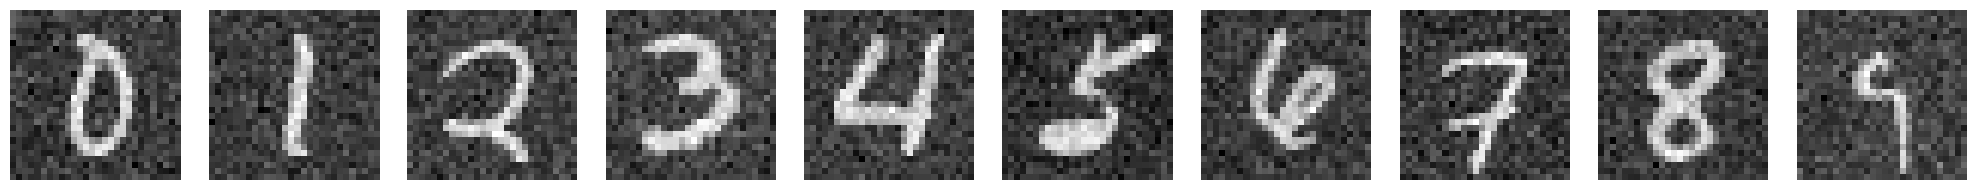

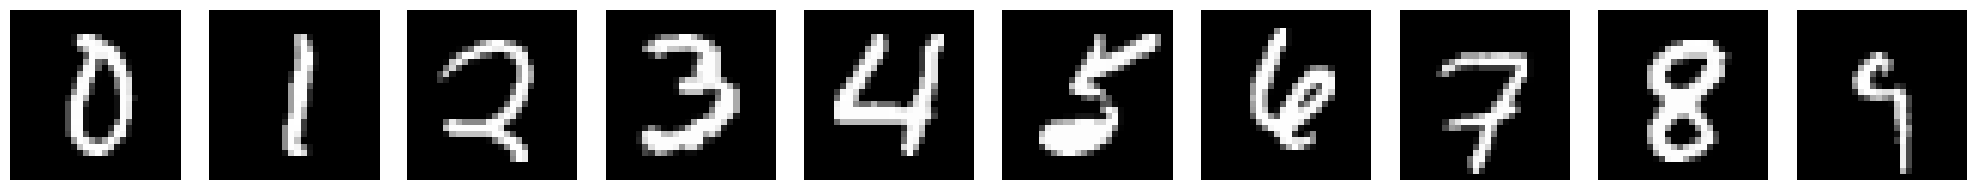

In [8]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(sampled_P_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_P_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/direct_fitting_compare.png', format='png', dpi=300)

plt.show()

## Data Augmentation with Log-Linear Model

### Legendre Decomposition (Many-Body Approximation)

In [9]:
B_LD = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_LD.shape)

def LD_helper(i, digit):
    _, _, scaleX, Q, theta = ld.LD(P_digit[digit][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, Q, theta)

results = Parallel(n_jobs=30)(delayed(LD_helper)(i, digit) for i in range(train_size) for digit in range(10))

scaleX_digit = []
Q_digit = []
theta_digit = []
X_recons_digit = []

for digit in range(10):
    scaleX_list = []
    Q_list = []
    theta_list = []
    X_recons_list = []
    for i in range(train_size):
        result = results[i*10 + digit]

        scaleX_list.append(result[0])
        Q_list.append(result[1])
        theta_list.append(result[2])
        X_recons = (result[1] * result[0]).astype(np.int32)
        X_recons_list.append(X_recons)

    scaleX_digit.append(np.array(scaleX_list))
    Q_digit.append(np.array(Q_list))
    theta_digit.append(np.array(theta_list))
    X_recons_digit.append(np.array(X_recons_list))

(107, 6)


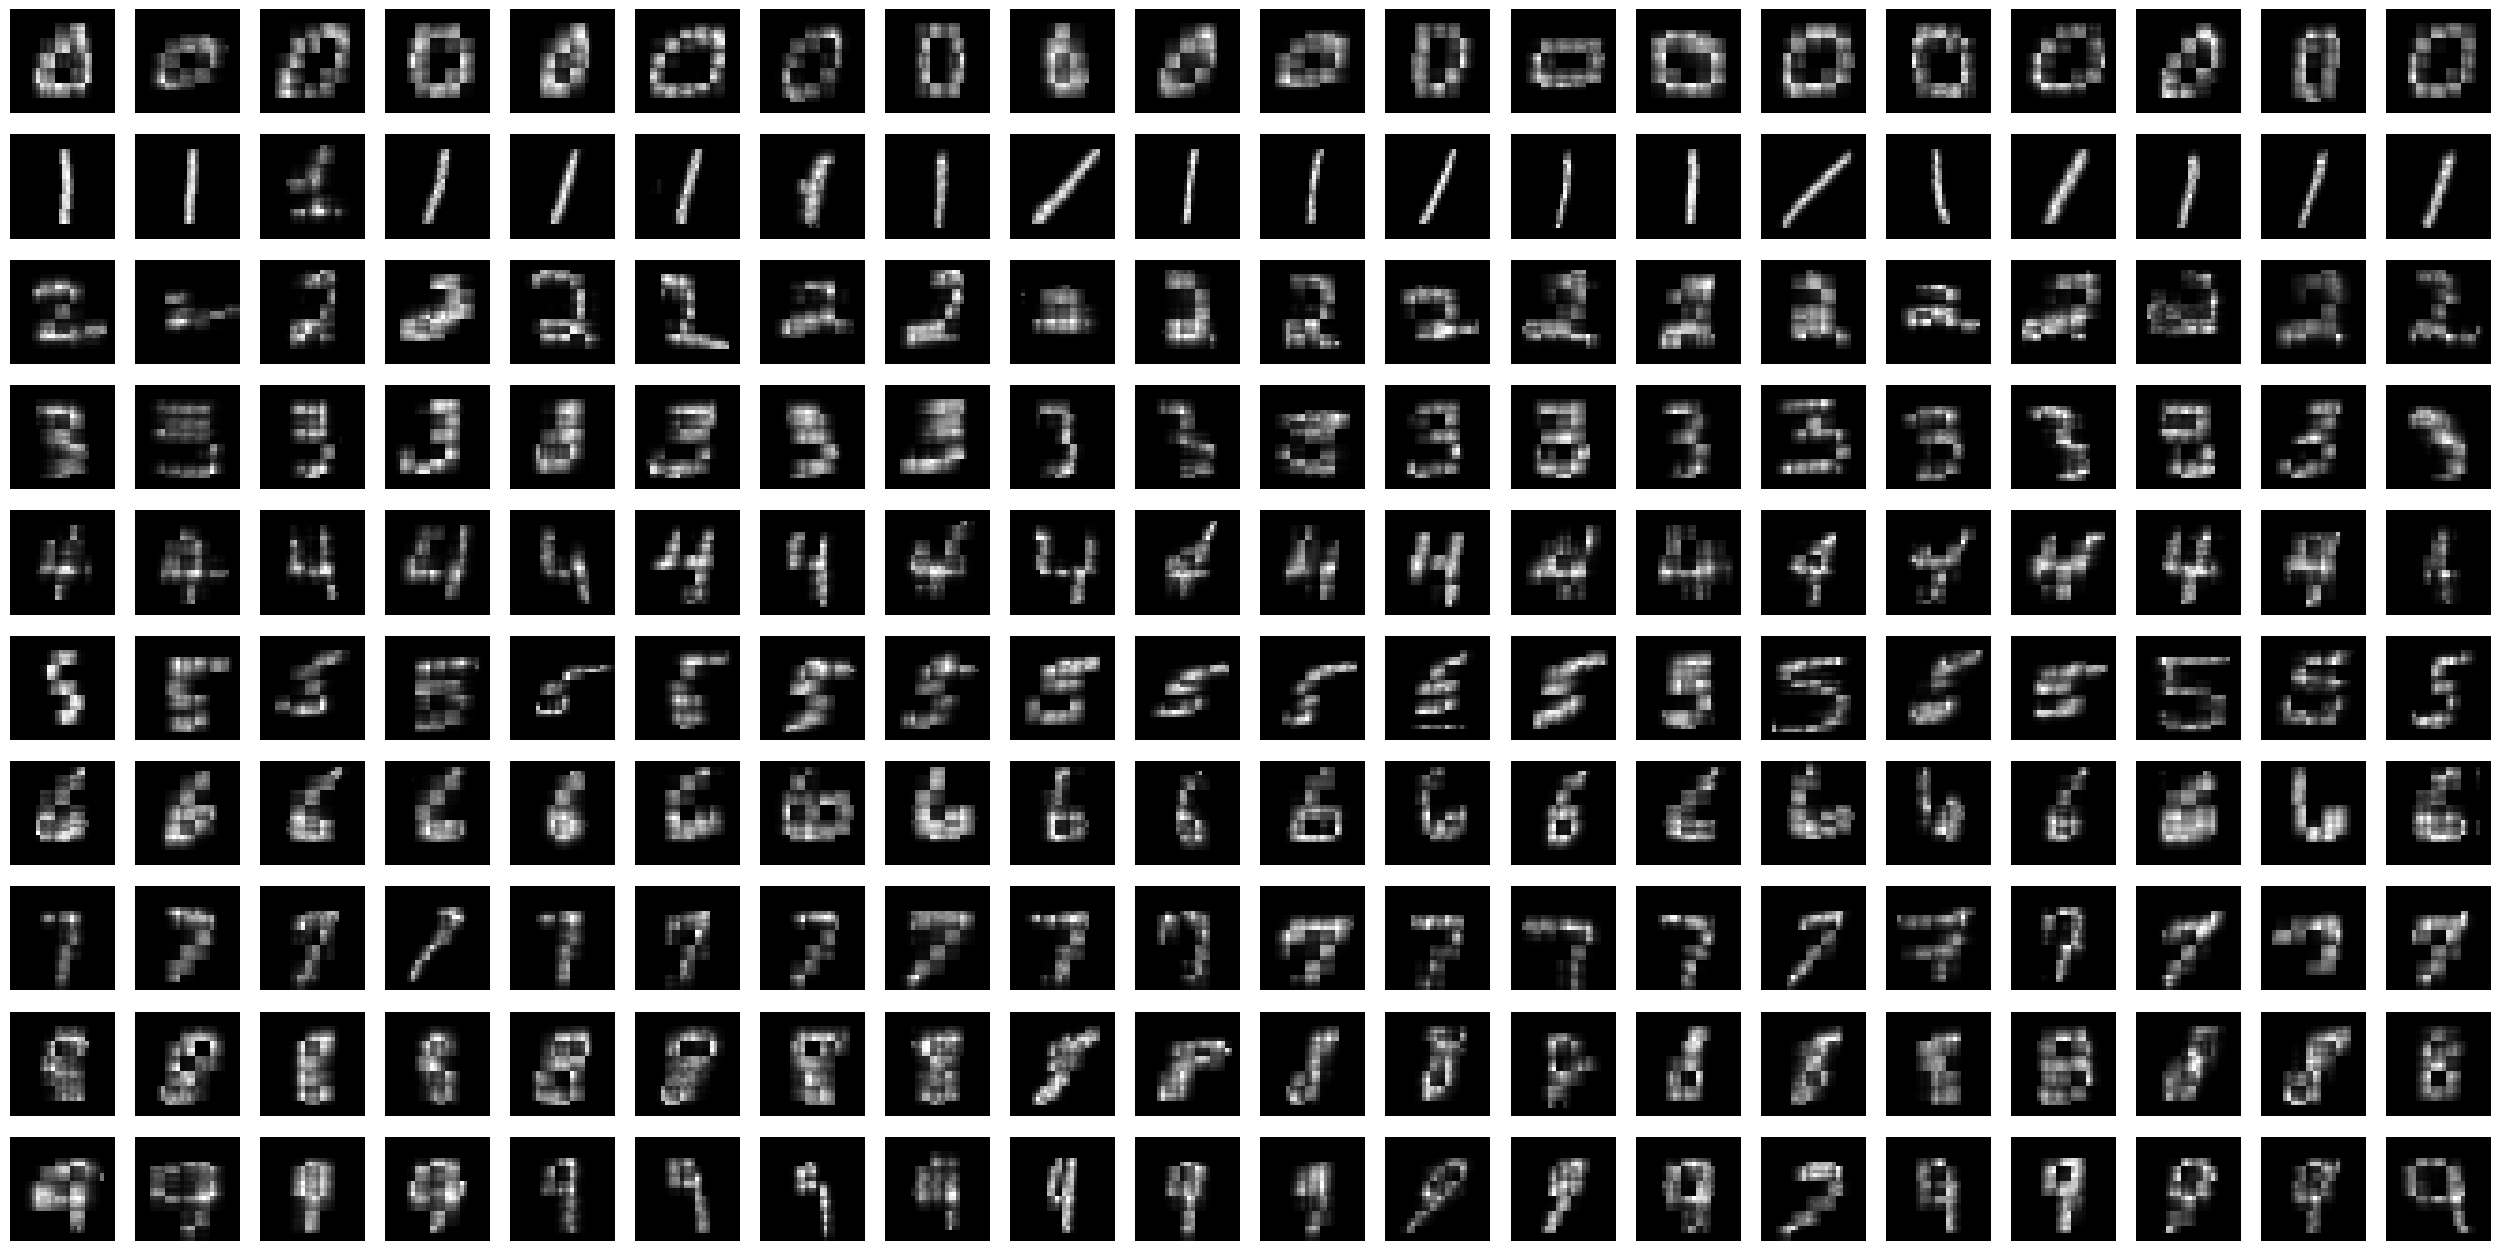

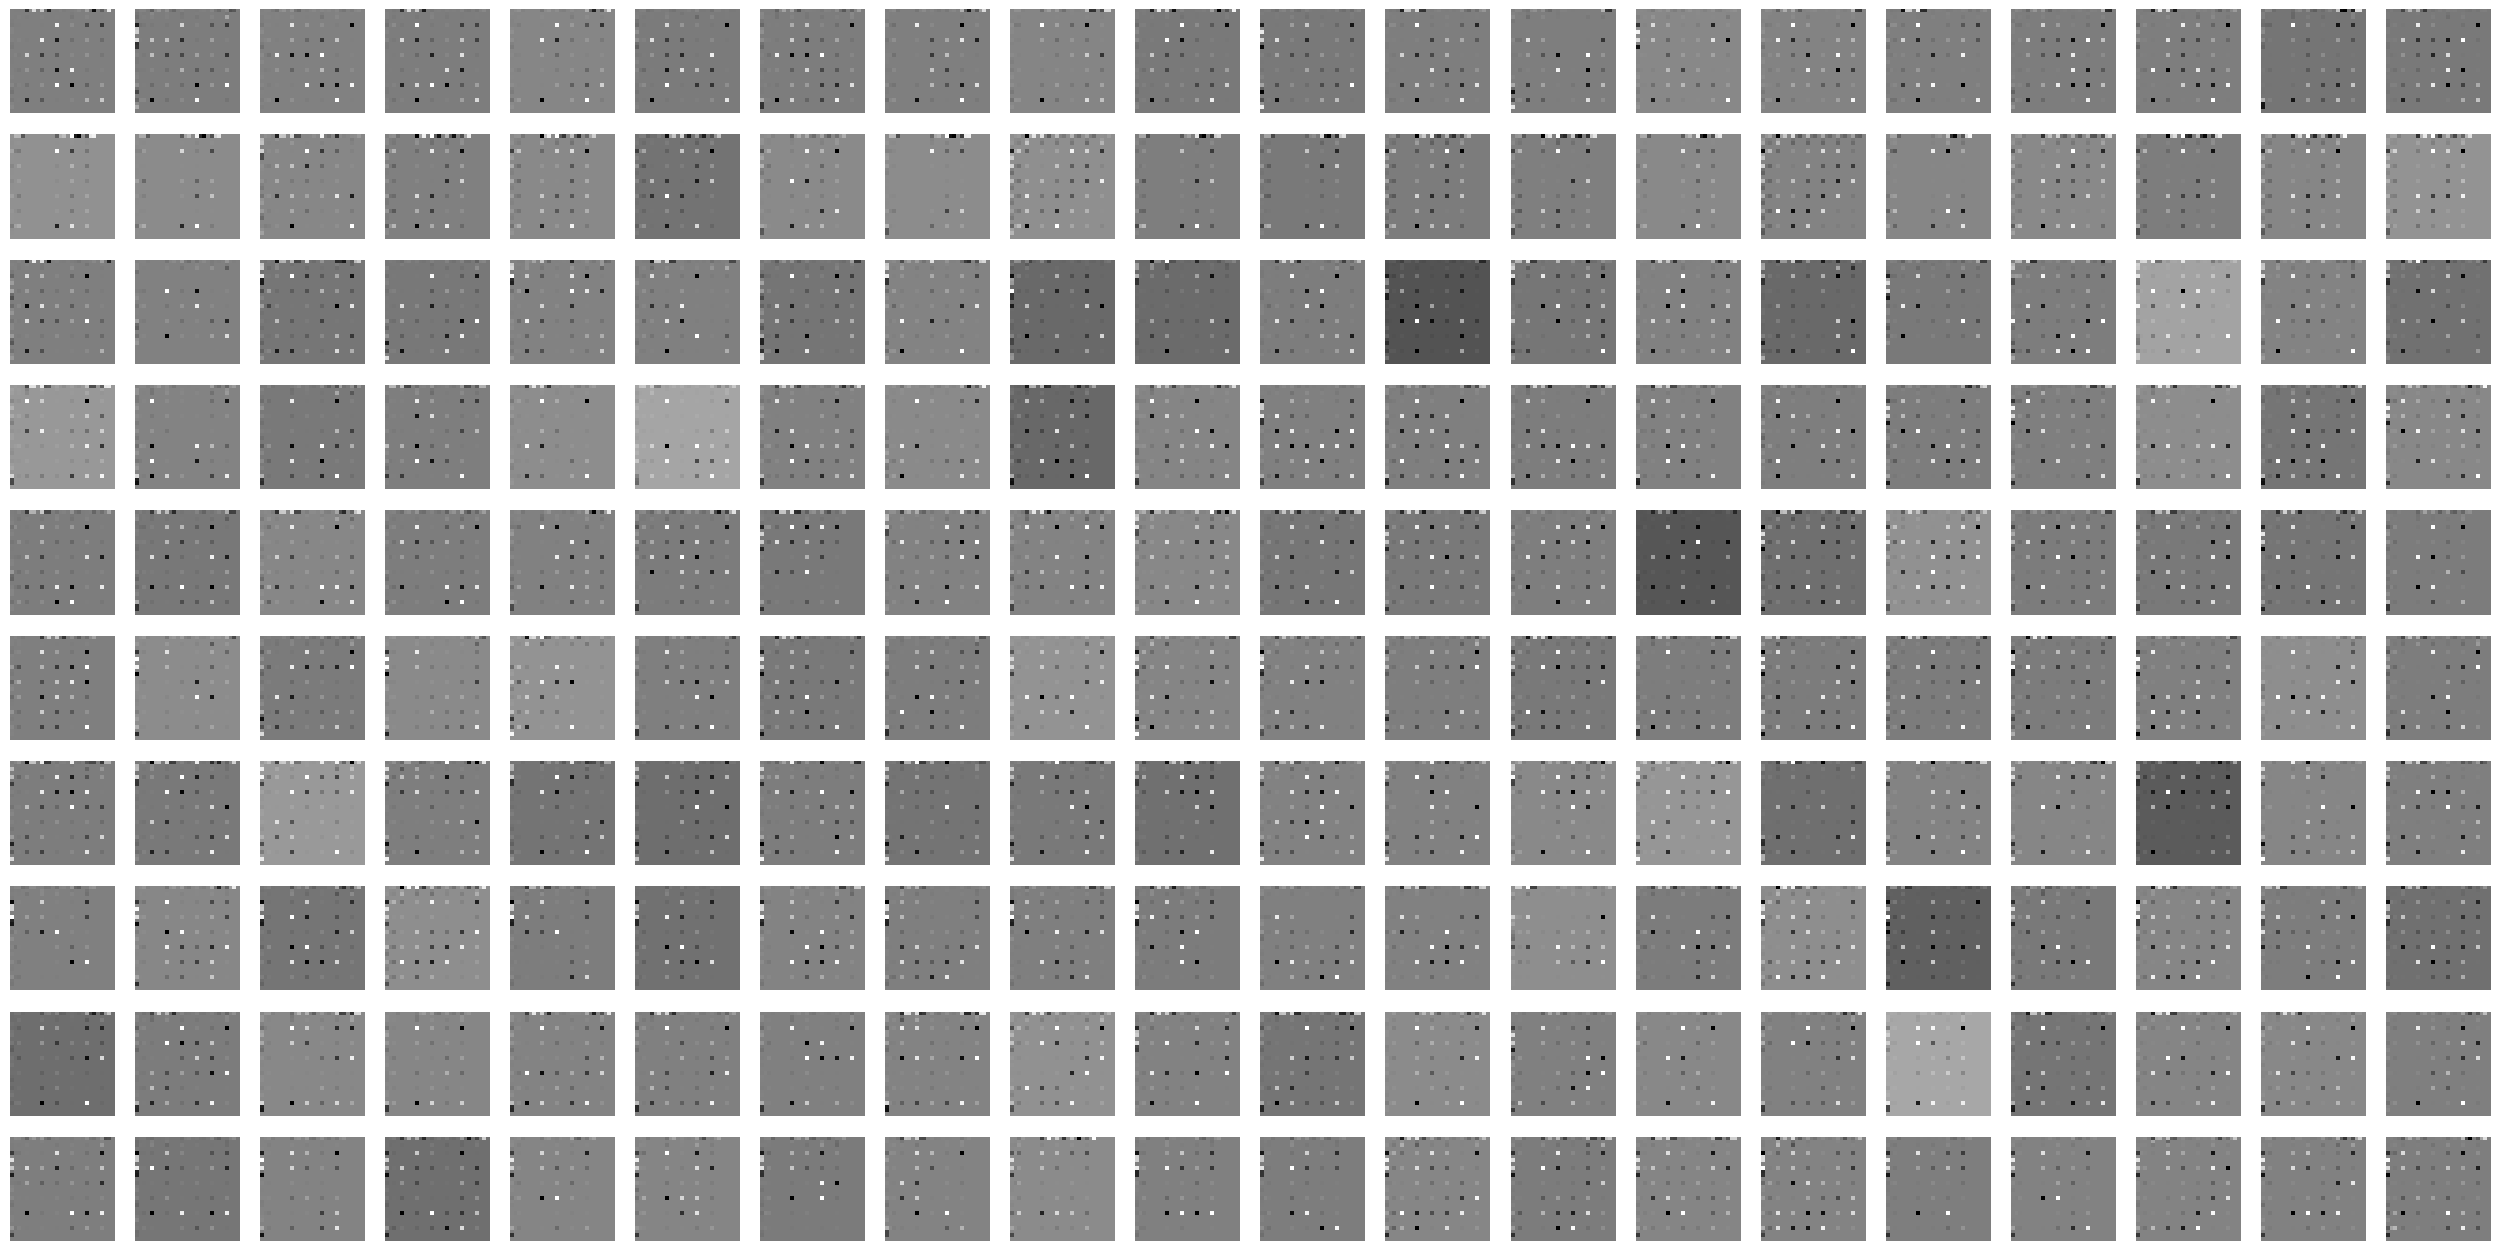

In [10]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

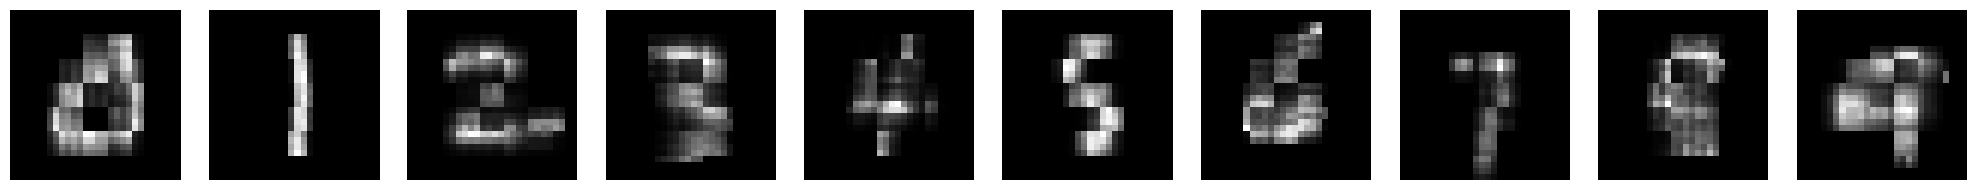

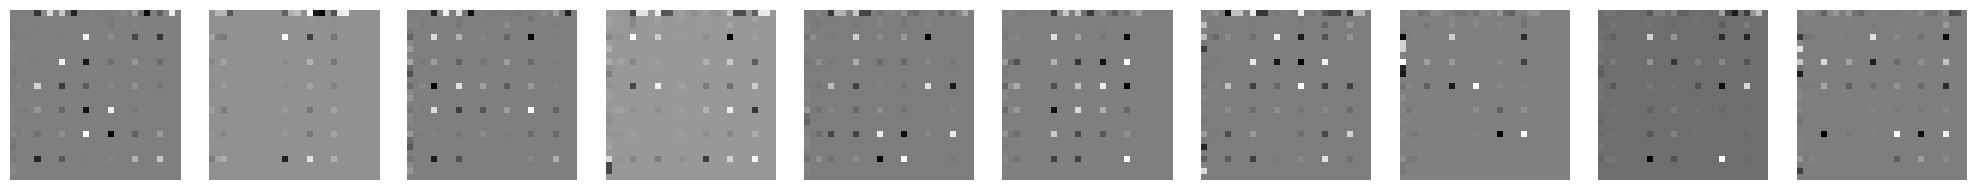

In [11]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_2_body_full_k=8_bandwidth=0.05/LD.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(theta_digit[digit][i].reshape((28, 28)), cmap='gray')
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_2_body_full_k=8_bandwidth=0.05/LD_parameter.png', format='png', dpi=300)

plt.show()

#### Fitting on Projected Points

In [12]:
sampled_theta_digit = []

for digit in range(10):
    reduced_theta = vectorize_tensor(theta_digit[digit], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)
    sampled_theta_digit.append(sampled_theta)

#### Construct Local Sub-Manifold

In [13]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_digit = []

for digit in range(10):
    eta_hat_list = []
    for i in range(P_digit[digit].shape[0]):
        xp = cp.get_array_module(P_digit[digit][i])
        P = (P_digit[digit][i] + eps) / scaleX_digit[digit][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_digit.append(cp.asarray(eta_hat_list))

(17, 6)


#### Backward Projection

In [14]:
def BP_helper(i, digit):
    N = ld.kNN(sampled_theta_digit[digit][i], theta_digit[digit], k=k)
    avg_scale = np.mean(scaleX_digit[digit][N])
    avg_eta_hat = np.mean(eta_hat_digit[digit][N], axis=0)
    _, _, P, theta = ld.BP(sampled_theta_digit[digit][i], [(P_digit[digit][j] + eps) / scaleX_digit[digit][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
    X_recons_ = (P).astype(np.int32).reshape(-1)
    return (P, theta, X_recons_)

results = Parallel(n_jobs=30)(delayed(BP_helper)(i, digit) for i in range(num_new_samples) for digit in range(10))

sampled_P_BP_digit = []
sampled_theta_BP_digit = []
sampled_X_recons_digit = []

for digit in range(10):
    sampled_P_BP = []
    sampled_theta_BP = []
    sampled_X_recons = []
    for i in range(num_new_samples):
        result = results[i*10 + digit]

        sampled_P_BP.append(result[0])
        sampled_theta_BP.append(result[1])
        sampled_X_recons.append(result[2])

    sampled_P_BP_digit.append(np.array(sampled_P_BP))
    sampled_theta_BP_digit.append(np.array(sampled_theta_BP))
    sampled_X_recons_digit.append(np.array(sampled_X_recons))

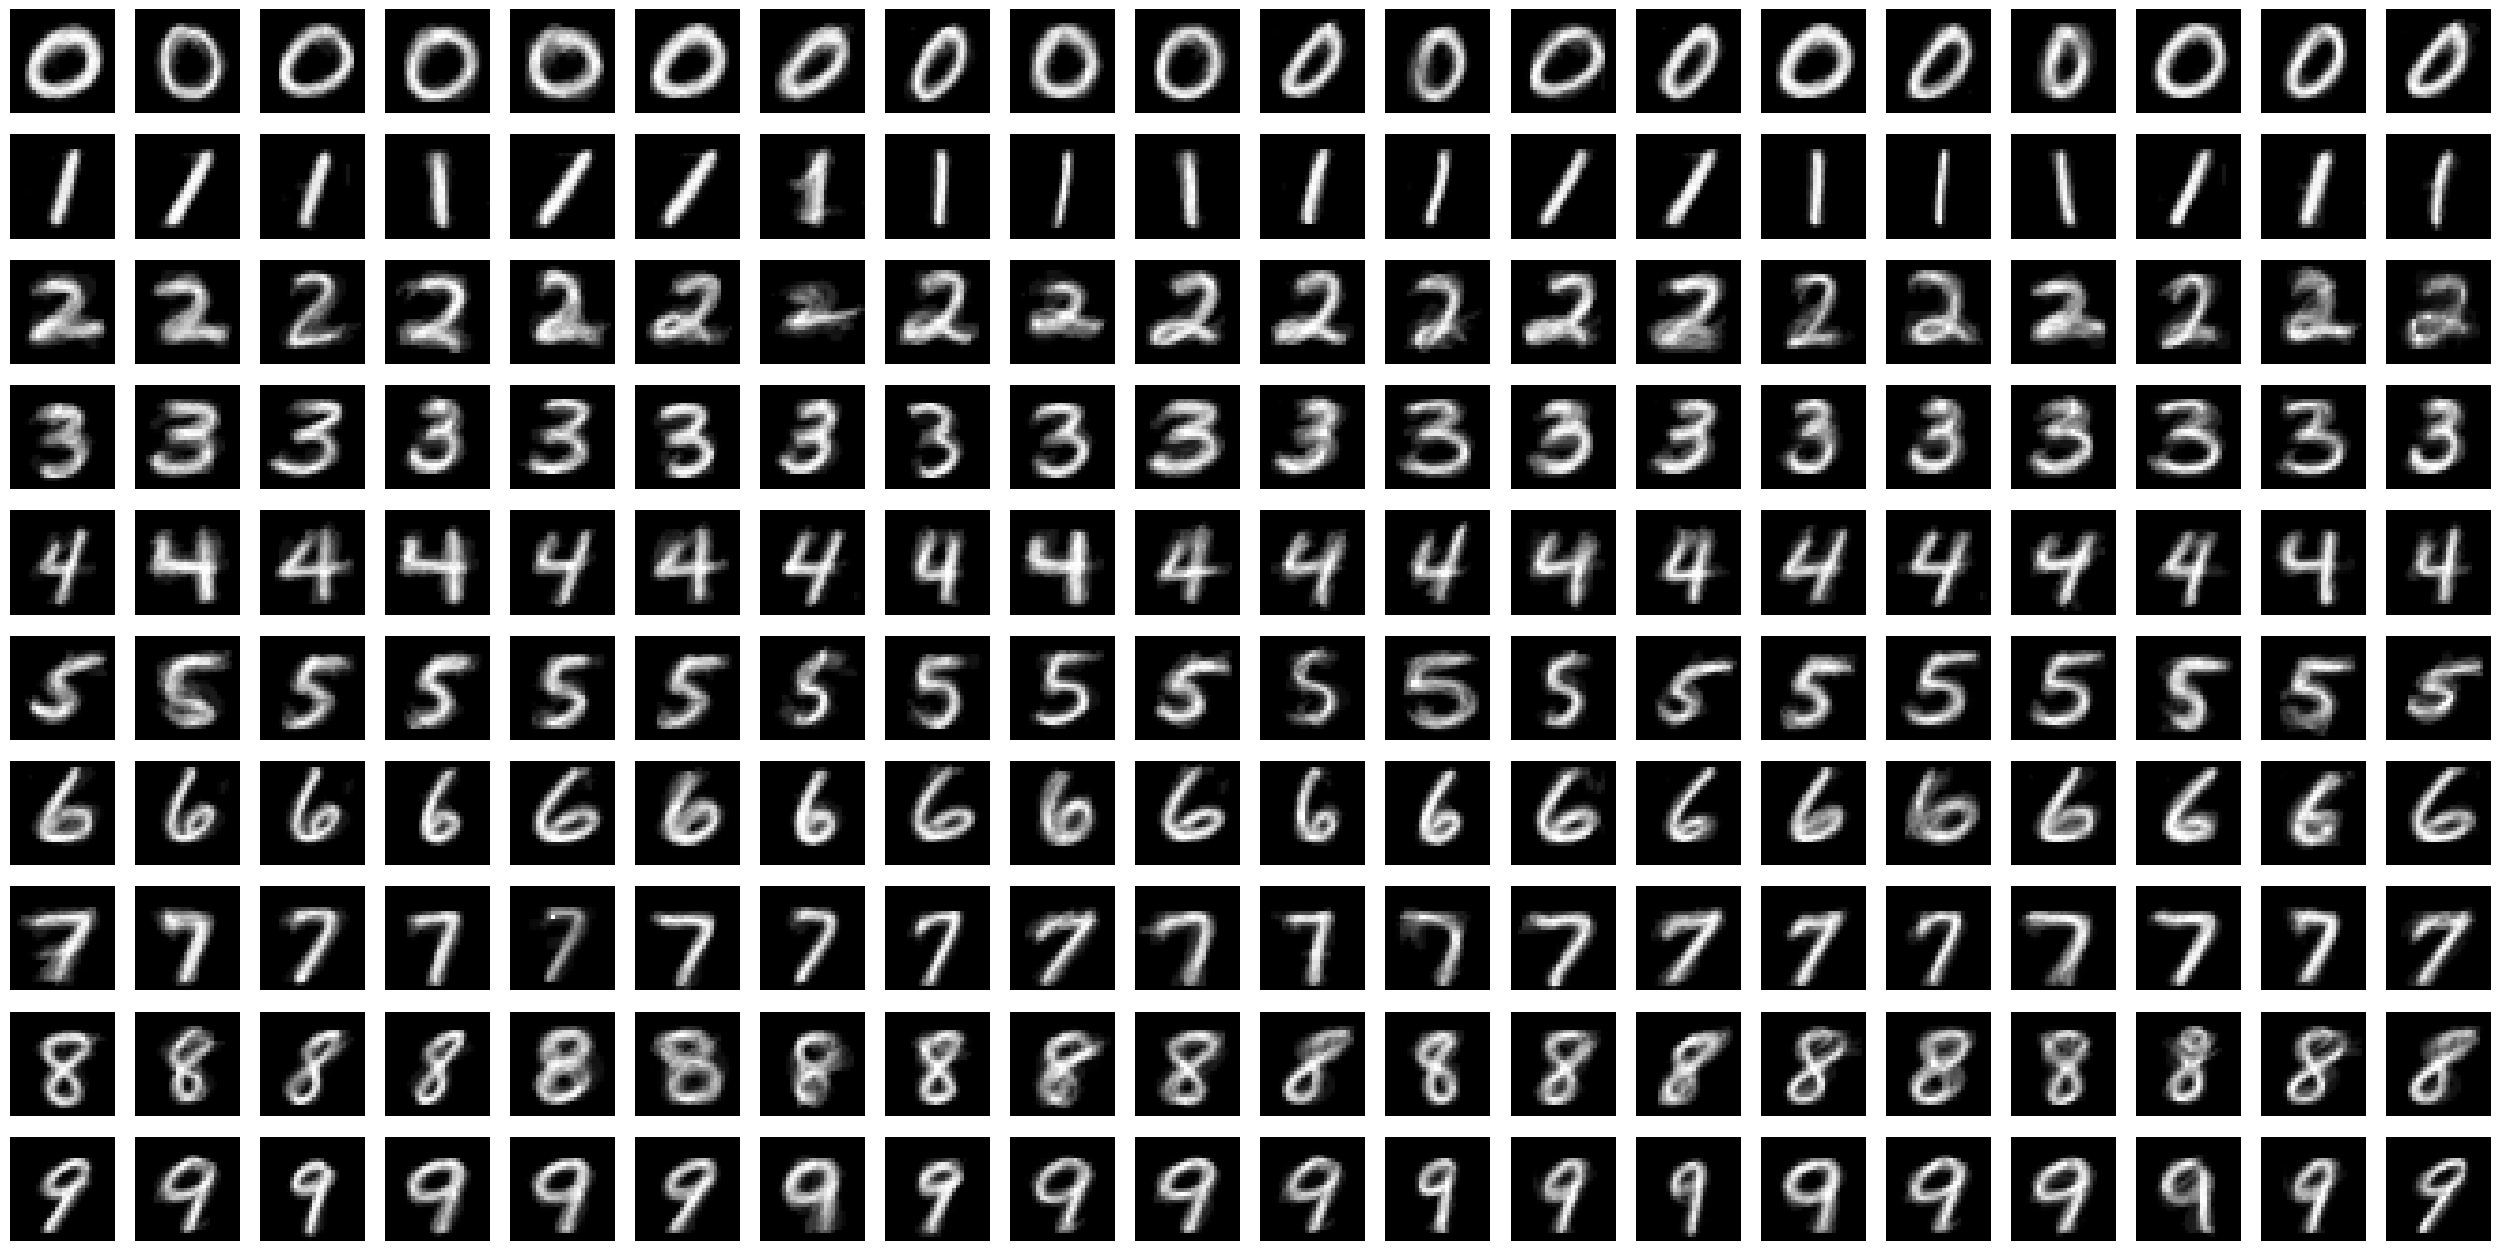

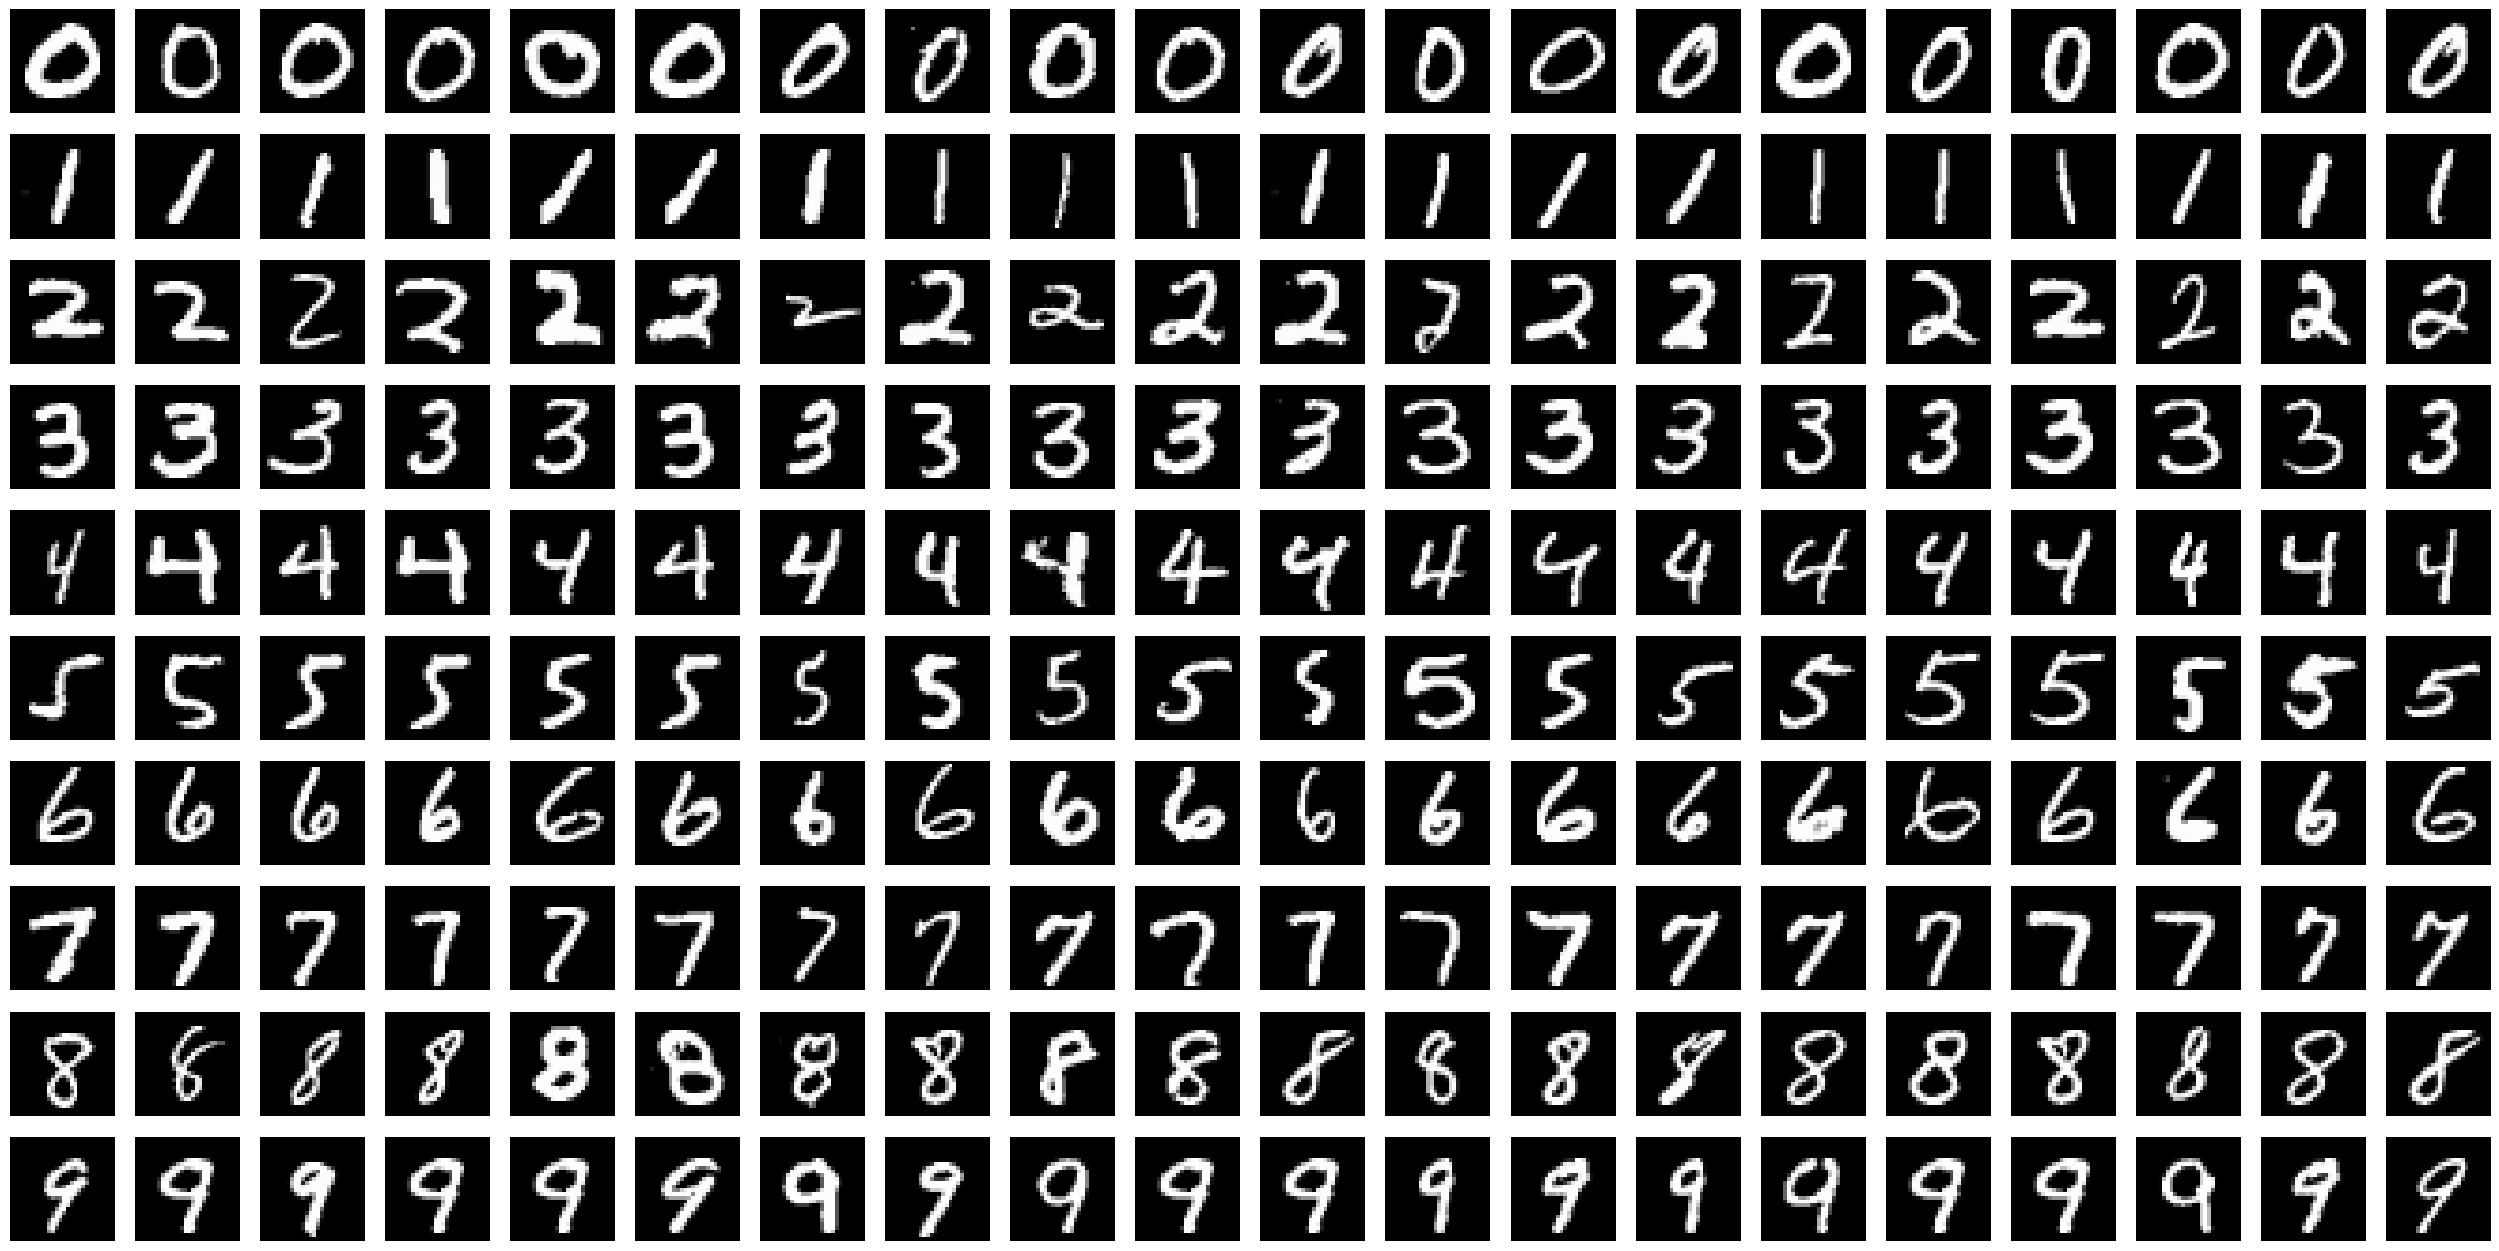

In [15]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

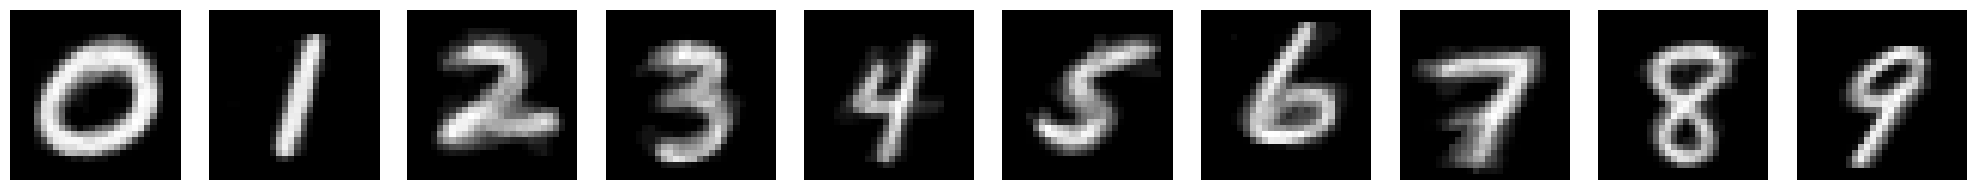

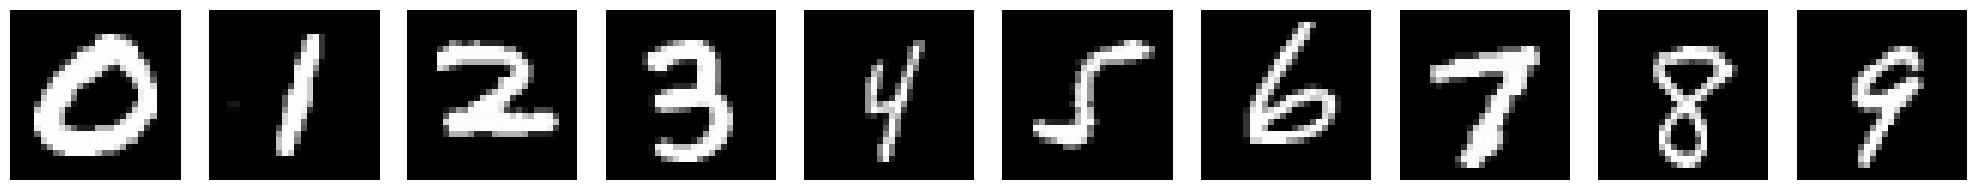

In [16]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_2_body_full_k=8_bandwidth=0.05/BP.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_recons_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(P_digit[digit][idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/default_2_body_full_k=8_bandwidth=0.05/BP_compare.png', format='png', dpi=300)

plt.show()

### Store Augmented Data

In [17]:
augmented_data_LD = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_X_recons_digit[digit][i]).reshape((28, 28))
        augmented_data_LD.append(img)

train_data_LD = np.array(augmented_data_LD)
labels = np.repeat(np.arange(10), num_new_samples)
custom_train_dataset = CustomDataset(train_data_LD, labels, transform=transforms.ToTensor())
train_loader_LD = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

### Interpolation

In [18]:
def interpolate_sum(theta_start, theta_end, interpolate_num, interpolate_B):
    """
    Perform interpolation between theta_start and theta_end and sum over specified indices.

    Parameters:
    theta_start (np.ndarray): Starting tensor.
    theta_end (np.ndarray): Ending tensor.
    interpolate_num (int): Number of interpolation steps.
    interpolate_B (list of tuples): Indices to sum over.

    Returns:
    np.ndarray: Array of interpolated tensors.
    """
    # Get the shape of the tensor
    tensor_shape = theta_start.shape

    # Create an array to store the interpolated tensors
    interpolated_thetas = np.zeros((interpolate_num,) + tensor_shape)

    # Iterate over the interpolation steps
    for i in range(interpolate_num):
        t = i / (interpolate_num - 1)  # Compute interpolation factor

        # Perform interpolation and sum over specified indices
        for basis in interpolate_B:
            index_slices = [slice(None)] * len(tensor_shape)
            index_slices = list(basis)
            interpolated_thetas[i][tuple(index_slices)] = (
                theta_start[tuple(index_slices)] + t * (theta_end[tuple(index_slices)] - theta_start[tuple(index_slices)])
            )

    return interpolated_thetas

In [19]:
theta_all = np.vstack(theta_digit)
scaleX_all = np.concatenate(scaleX_digit, axis=0)
P_all = np.vstack(P_digit)
eta_hat_all = np.vstack(eta_hat_digit)

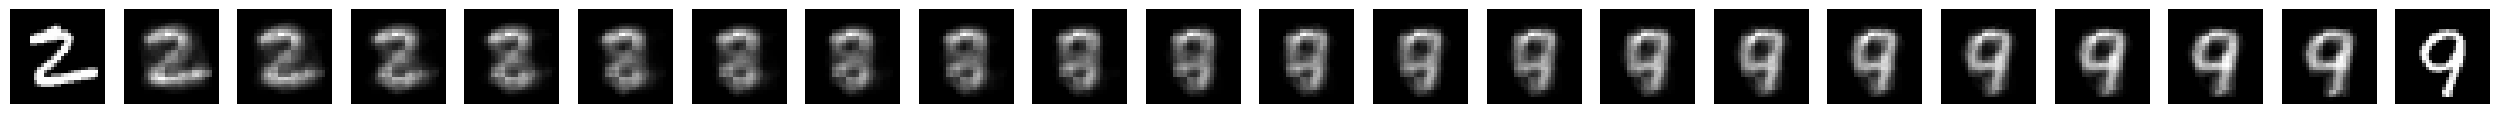

In [20]:
start_digit, end_digit = 2, 9
start_idx, end_idx = 0, 13

B_interpolate = ld.default_B(S, len(S), cp.get_array_module(P_digit[0][0]))
# B_interpolate = ld.block_B([1, 0, 0, 1, 0, 0], [6, 1, 1, 6, 1, 1])

theta_start, theta_end = theta_digit[start_digit][start_idx], theta_digit[end_digit][end_idx]

interpolate_num = 20

interpolate_theta = interpolate_sum(theta_start, theta_end, interpolate_num, B_interpolate)

interpolate_P_BP = []
interpolate_theta_BP = []
interpolate_X_recons = []

for i in range(interpolate_num):
    N = ld.kNN(interpolate_theta[i], np.vstack(theta_digit), k=20)
    avg_scale = np.mean(scaleX_all[N])
    avg_eta_hat = np.mean(eta_hat_all[N], axis=0)

    history_kl, history_norm, P, theta = ld.BP(interpolate_theta[i], [(P_all[j] + eps) / scaleX_all[j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
    interpolate_P_BP.append(P)
    interpolate_theta_BP.append(theta)

    X_recons_ = (P).astype(np.int32)
    interpolate_X_recons.append(X_recons_)

interpolate_P_BP = np.array(interpolate_P_BP)
interpolate_theta_BP = np.array(interpolate_theta_BP)
interpolate_X_recons = np.array(interpolate_X_recons)

plt.figure(figsize=(32, 3))
plt.subplot(1, interpolate_num+2, 1)
plt.imshow(P_digit[start_digit][start_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
for i in range(interpolate_num):
    plt.subplot(1, interpolate_num+2, i + 2)
    plt.imshow(renormalize_image(interpolate_X_recons[i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

plt.subplot(1, interpolate_num+2, interpolate_num + 2)
plt.imshow(P_digit[end_digit][end_idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

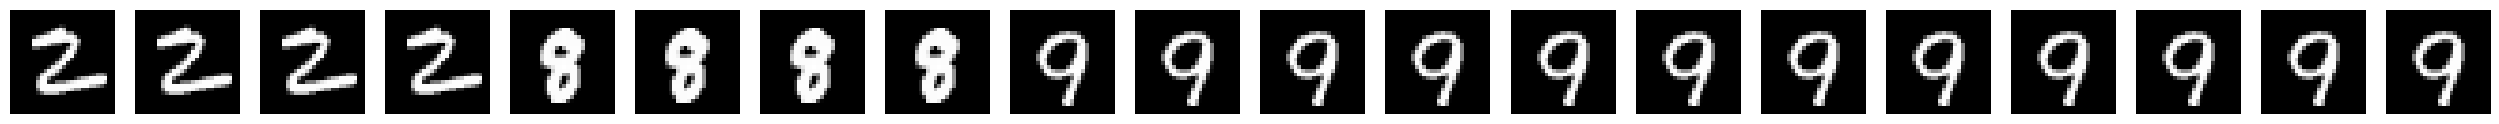

In [21]:
# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 3))

for i in range(interpolate_num):
    norm = [np.linalg.norm(interpolate_X_recons[i].reshape((28, 28)) - p.reshape((28, 28))) for p in P_all]
    idx = np.argmin(norm)
    # print(f"Nearest distance: new sample {i} and training sample {idx}: {norm[idx]}")

    plt.subplot(1, interpolate_num, i+1)
    plt.imshow(P_all[idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()

## Data Augmentation with Autoencoder

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size2)
        self.fc3 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=28*28, hidden_size=128, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [23]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

100%|██████████| 500/500 [00:24<00:00, 20.75it/s]


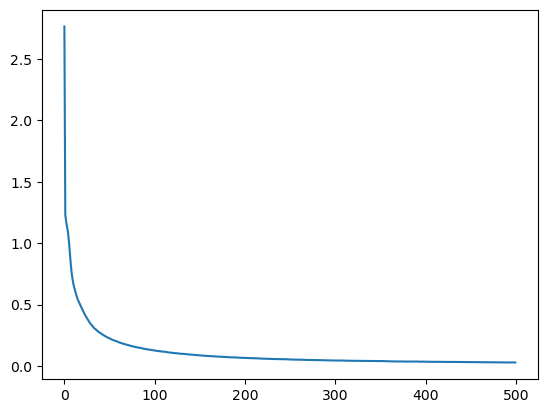

In [24]:
train_loss = []
num_epochs = 500

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (imgs , _) in train_loader_original:
        imgs = imgs.to(device)
        #100 , 1 , 28 , 28 ---> (100 , 28*28)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

In [25]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_digit = []
for digit in range(10):
    AE_digit.append(AE_imgs[torch.tensor(all_labels) == digit])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [26]:
num_new_samples = 20

sampled_AE_digit = []

for digit in range(10):
    sampled_AE_list = []

    rep = representation[np.argwhere(all_labels == digit)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=num_new_samples)
    for i in range(num_new_samples):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_AE_list.append(pred)

    sampled_AE_digit.append(sampled_AE_list)

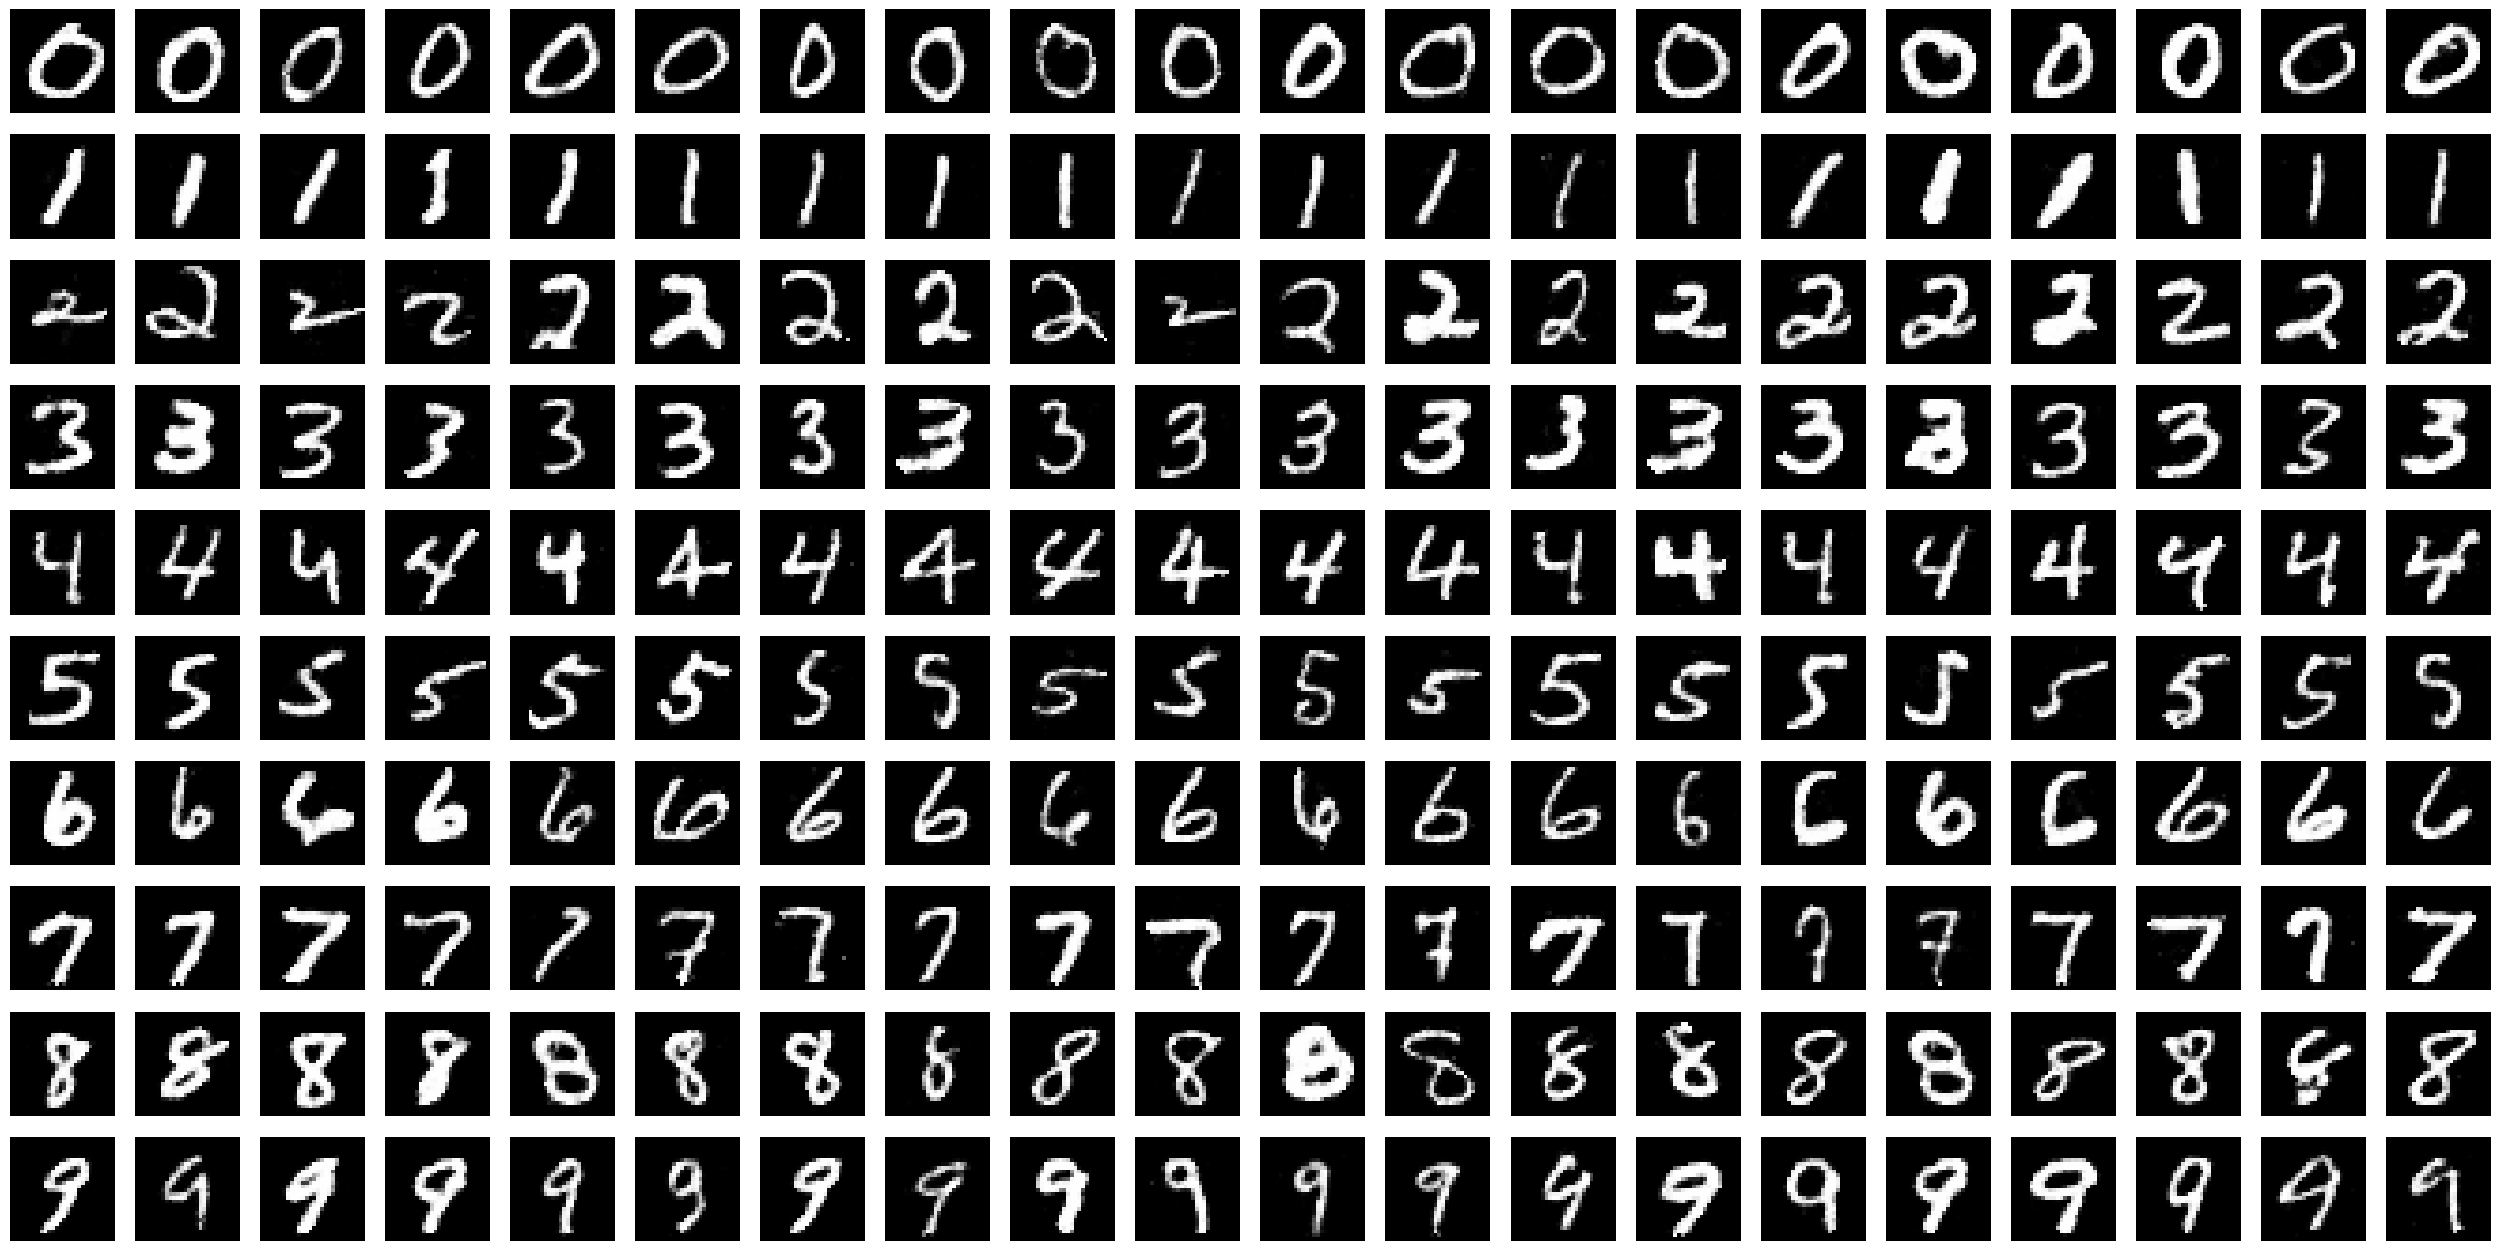

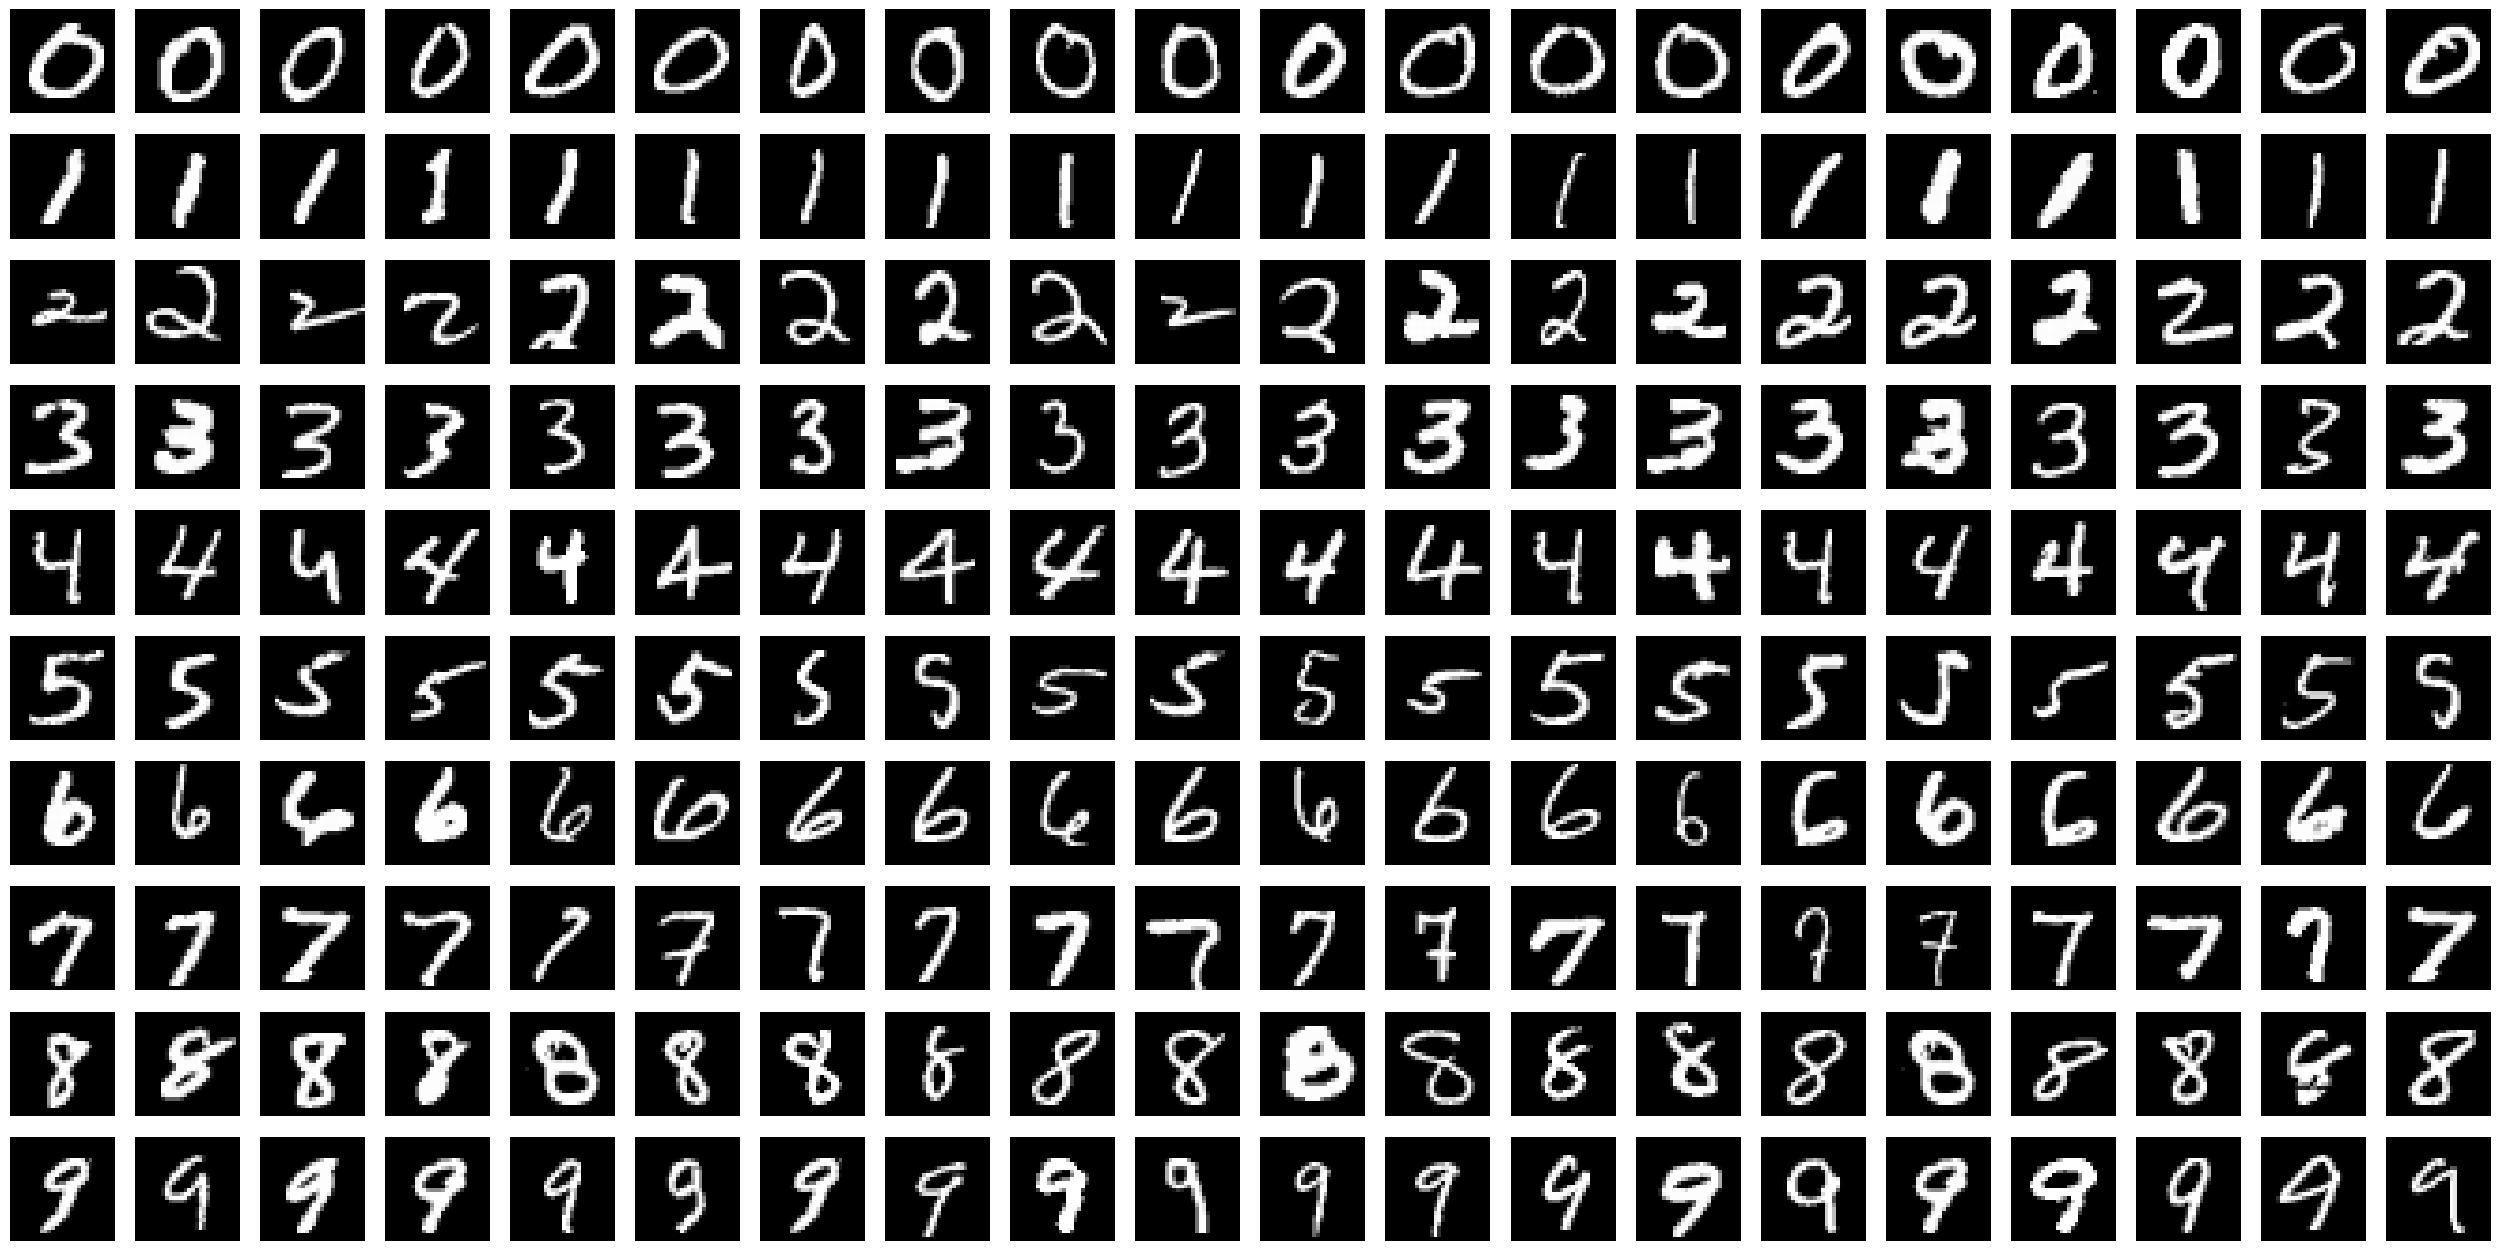

In [27]:
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for digit in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, digit * plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

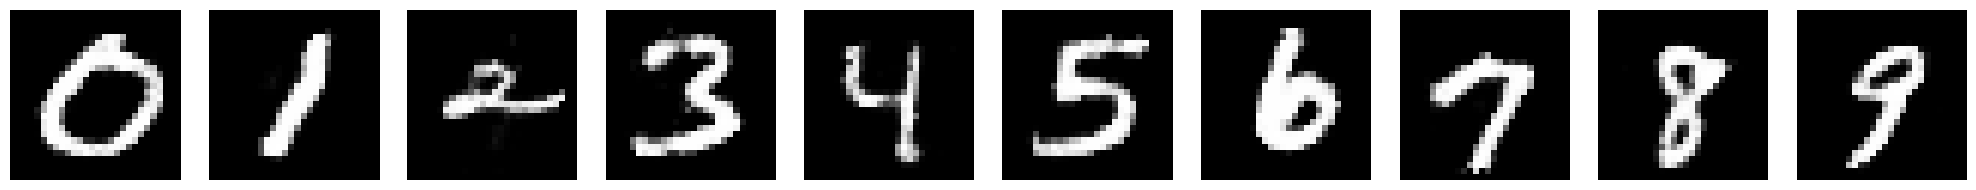

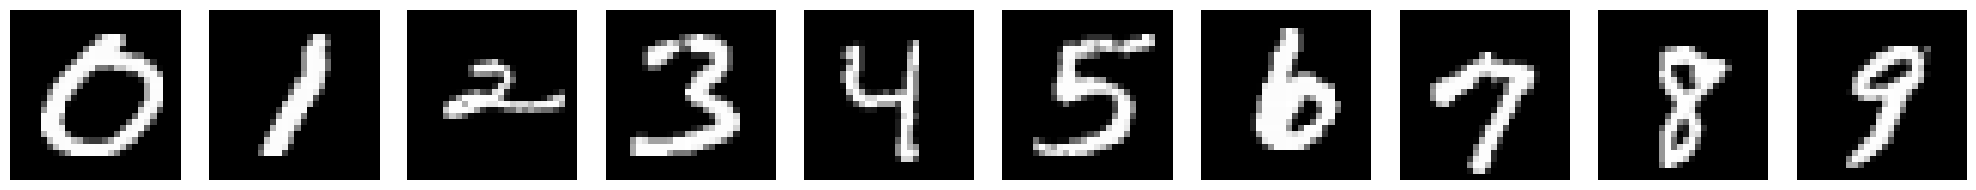

In [28]:
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_AE_digit[digit][i]).reshape(28, 28), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE.png', format='png', dpi=300)

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for digit in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_AE_digit[digit][i].reshape((28, 28)) - p.reshape((28, 28))) for p in AE_digit[digit]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, digit * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_digit[digit][idx]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/MNIST/else/AE_compare.png', format='png', dpi=300)

plt.show()

### Store Augmented Data

In [29]:
augmented_data_AE = []

for digit in range(10):
    for i in range(num_new_samples):
        img = renormalize_image(sampled_AE_digit[digit][i]).reshape((28, 28))
        augmented_data_AE.append(img)

train_data_AE = np.array(augmented_data_AE)
labels = np.repeat(np.arange(10), num_new_samples)
custom_train_dataset = CustomDataset(train_data_AE, labels, transform=transforms.ToTensor())
train_loader_AE = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)

## Classification Performance

### Logistic Regression Model

In [30]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(28*28, 10)  # 28x28 input size, 10 output classes

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image into a vector of size 28*28
        out = self.linear(x)   # Linear transformation
        return out

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to test the model
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy

# Main function to run training and testing on a dataset
def run(train_loader, test_loader, num_epochs=5, learning_rate=0.01, device='cpu'):
    # Initialize model, loss function, and optimizer
    model = LogisticRegressionModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Test the model
    accuracy = test_model(model, test_loader, device=device)
    return accuracy

In [31]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"Number of test samples: {len(test_loader.dataset)}")

Number of test samples: 10000


### Original Dataset

In [32]:
accuracy = run(train_loader_original, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2677
Epoch [2/20], Loss: 2.0970
Epoch [3/20], Loss: 1.9466
Epoch [4/20], Loss: 1.8164
Epoch [5/20], Loss: 1.7004
Epoch [6/20], Loss: 1.5976
Epoch [7/20], Loss: 1.5117
Epoch [8/20], Loss: 1.4321
Epoch [9/20], Loss: 1.3657
Epoch [10/20], Loss: 1.3051
Epoch [11/20], Loss: 1.2509
Epoch [12/20], Loss: 1.2014
Epoch [13/20], Loss: 1.1531
Epoch [14/20], Loss: 1.1140
Epoch [15/20], Loss: 1.0762
Epoch [16/20], Loss: 1.0411
Epoch [17/20], Loss: 1.0156
Epoch [18/20], Loss: 0.9830
Epoch [19/20], Loss: 0.9590
Epoch [20/20], Loss: 0.9338
Accuracy of the model on the test images: 82.40%
Final Test Accuracy on MNIST: 82.40%


### Augmented Dataset

#### Log-Linear Model

In [33]:
accuracy = run(train_loader_LD, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2932
Epoch [2/20], Loss: 2.2232
Epoch [3/20], Loss: 2.1741
Epoch [4/20], Loss: 2.1247
Epoch [5/20], Loss: 2.0850
Epoch [6/20], Loss: 2.0108
Epoch [7/20], Loss: 1.9543
Epoch [8/20], Loss: 1.9357
Epoch [9/20], Loss: 1.8635
Epoch [10/20], Loss: 1.8359
Epoch [11/20], Loss: 1.7815
Epoch [12/20], Loss: 1.7311
Epoch [13/20], Loss: 1.7387
Epoch [14/20], Loss: 1.6465
Epoch [15/20], Loss: 1.6178
Epoch [16/20], Loss: 1.6044
Epoch [17/20], Loss: 1.5465
Epoch [18/20], Loss: 1.5290
Epoch [19/20], Loss: 1.5054
Epoch [20/20], Loss: 1.5331
Accuracy of the model on the test images: 72.52%
Final Test Accuracy on MNIST: 72.52%


#### Autoencoder

In [34]:
accuracy = run(train_loader_AE, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.3005
Epoch [2/20], Loss: 2.2237
Epoch [3/20], Loss: 2.2125
Epoch [4/20], Loss: 2.1139
Epoch [5/20], Loss: 2.0881
Epoch [6/20], Loss: 2.0121
Epoch [7/20], Loss: 1.9861
Epoch [8/20], Loss: 1.9286
Epoch [9/20], Loss: 1.8983
Epoch [10/20], Loss: 1.8757
Epoch [11/20], Loss: 1.8203
Epoch [12/20], Loss: 1.7794
Epoch [13/20], Loss: 1.7627
Epoch [14/20], Loss: 1.6932
Epoch [15/20], Loss: 1.7205
Epoch [16/20], Loss: 1.6321
Epoch [17/20], Loss: 1.5963
Epoch [18/20], Loss: 1.6169
Epoch [19/20], Loss: 1.5595
Epoch [20/20], Loss: 1.4975
Accuracy of the model on the test images: 67.78%
Final Test Accuracy on MNIST: 67.78%


### Original and Augmented Dataset

#### Log-Linear Model

In [35]:
train_data = np.vstack([train_data_original, train_data_LD])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)
accuracy = run(train_loader, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.1875
Epoch [2/20], Loss: 1.9919
Epoch [3/20], Loss: 1.8252
Epoch [4/20], Loss: 1.6835
Epoch [5/20], Loss: 1.5619
Epoch [6/20], Loss: 1.4573
Epoch [7/20], Loss: 1.3643
Epoch [8/20], Loss: 1.2848
Epoch [9/20], Loss: 1.2142
Epoch [10/20], Loss: 1.1532
Epoch [11/20], Loss: 1.1023
Epoch [12/20], Loss: 1.0542
Epoch [13/20], Loss: 1.0115
Epoch [14/20], Loss: 0.9722
Epoch [15/20], Loss: 0.9369
Epoch [16/20], Loss: 0.9067
Epoch [17/20], Loss: 0.8807
Epoch [18/20], Loss: 0.8527
Epoch [19/20], Loss: 0.8293
Epoch [20/20], Loss: 0.8068
Accuracy of the model on the test images: 82.55%
Final Test Accuracy on MNIST: 82.55%


#### Autoencoder

In [36]:
train_data = np.vstack([train_data_original, train_data_AE])
labels = np.hstack([np.repeat(np.arange(10), train_size), np.repeat(np.arange(10), num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=64, shuffle=True)
accuracy = run(train_loader, test_loader, num_epochs=20, learning_rate=0.01, device=device)
print(f'Final Test Accuracy on MNIST: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.2259
Epoch [2/20], Loss: 2.0280
Epoch [3/20], Loss: 1.8615
Epoch [4/20], Loss: 1.7208
Epoch [5/20], Loss: 1.6000
Epoch [6/20], Loss: 1.4952
Epoch [7/20], Loss: 1.4038
Epoch [8/20], Loss: 1.3233
Epoch [9/20], Loss: 1.2564
Epoch [10/20], Loss: 1.1954
Epoch [11/20], Loss: 1.1441
Epoch [12/20], Loss: 1.0953
Epoch [13/20], Loss: 1.0552
Epoch [14/20], Loss: 1.0171
Epoch [15/20], Loss: 0.9824
Epoch [16/20], Loss: 0.9533
Epoch [17/20], Loss: 0.9264
Epoch [18/20], Loss: 0.8999
Epoch [19/20], Loss: 0.8766
Epoch [20/20], Loss: 0.8536
Accuracy of the model on the test images: 82.92%
Final Test Accuracy on MNIST: 82.92%
